# Understanding State Dataset

In [2]:
# Cell 1: Imports & Constants
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

SIG_NUM   = 3        # number of features per time step
STATE_NUM = 1        # binary latent state
P_S0      = [0.5]    # initial P(state=1)

# Which feature is “important” in state 0 and 1
imp_feature = [1, 2]

# Per‐state mean vectors
scale = [
    [ 0.1,  1.6,  0.5],   # μ when state=0
    [-0.1, -0.4, -1.5]    # μ when state=1
]


In [3]:
# Cell 2: Distribution Parameters & State Logic
def init_distribution_params():
    """Return (means, covariances) arrays of shape (2, SIG_NUM) and (2, SIG_NUM, SIG_NUM)."""
    cov_base = np.eye(SIG_NUM) * 0.8
    means, covs = [], []
    for s in range(2**STATE_NUM):
        c = cov_base.copy()
        # tiny correlation between imp_feature[s] and feature 0
        c[imp_feature[s], 0] = c[0, imp_feature[s]] = 0.01
        c += np.eye(SIG_NUM) * 1e-3
        means.append(scale[s])
        covs.append(c)
    return np.array(means), np.array(covs)

def next_state(prev, dwell):
    """Bernoulli transition: p=0.95−dwell/500 if prev=1, else 0.05."""
    p = 0.95 if prev == 1 else 0.05
    if p > 0.8:
        p -= dwell / 500
    return np.random.binomial(1, p)

def logit(x):
    """Logistic mapping for label probability."""
    return 1.0 / (1.0 + np.exp(-2.0 * x))

# Sanity‐check shapes
means, covs = init_distribution_params()
print("means:", means.shape, "covs:", covs.shape)


means: (2, 3) covs: (2, 3, 3)


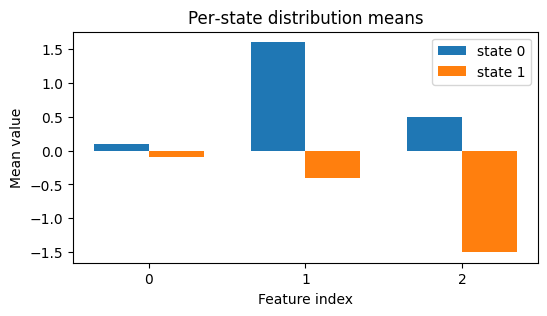

In [4]:
# Cell 2.1 — Bar plot of per‐state mean vectors
import matplotlib.pyplot as plt

# means.shape == (2, SIG_NUM)
fig, ax = plt.subplots(figsize=(6,3))
states = [f"state {s}" for s in range(means.shape[0])]
x = np.arange(SIG_NUM)
width = 0.35

ax.bar(x - width/2, means[0], width, label=states[0])
ax.bar(x + width/2, means[1], width, label=states[1])
ax.set_xlabel("Feature index")
ax.set_ylabel("Mean value")
ax.set_title("Per‐state distribution means")
ax.set_xticks(x)
ax.legend()
plt.show()


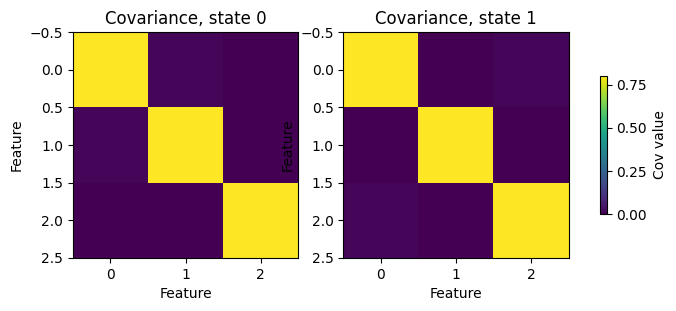

In [5]:
# Cell 2.2 — Heatmaps of the covariance matrices
fig, axes = plt.subplots(1, 2, figsize=(8,3))
for s, ax in enumerate(axes):
    im = ax.imshow(covs[s], vmin=0, vmax=np.max(covs), cmap='viridis')
    ax.set_title(f"Covariance, state {s}")
    ax.set_xlabel("Feature")
    ax.set_ylabel("Feature")
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label="Cov value")
# plt.tight_layout()
plt.show()


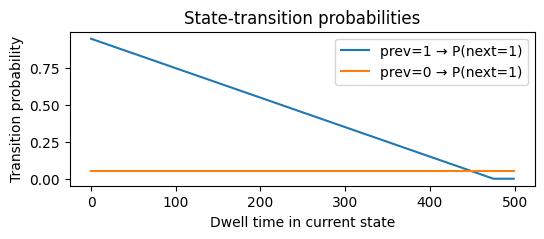

In [6]:
# Cell 2.3 — Transition probability vs. dwell‐time
dwells = np.arange(0, 500)
p1 = [max(0.95 - d/500, 0) for d in dwells]
p0 = [0.05] * len(dwells)

plt.figure(figsize=(6,2))
plt.plot(dwells, p1, label="prev=1 → P(next=1)")
plt.plot(dwells, p0, label="prev=0 → P(next=1)")
plt.xlabel("Dwell time in current state")
plt.ylabel("Transition probability")
plt.title("State‐transition probabilities")
plt.legend()
plt.show()


In [7]:
# Cell 3: Single‐Signal Generator
def create_signal(length, means, covariances):
    """
    Returns:
      signal    : np.array of shape (SIG_NUM, length)
      y         : np.array of shape (length,)
      states    : list of length
      imp_mask  : np.array of shape (length, SIG_NUM)
      y_logits  : np.array of shape (length,)
    """
    signal   = np.zeros((SIG_NUM, length))
    states   = np.zeros(length, dtype=int)
    imp_mask = np.zeros((length, SIG_NUM))
    y        = np.zeros(length, dtype=int)
    y_logits = np.zeros(length)

    prev, dwell = np.random.binomial(1, P_S0)[0], 0
    for t in range(length):
        nxt = next_state(prev, dwell)
        dwell = dwell + 1 if nxt == prev else 0

        mask = np.zeros(SIG_NUM)
        if t == 0 or nxt != prev:
            mask[imp_feature[nxt]] = 1

        x_t = np.random.multivariate_normal(means[nxt], covariances[nxt])
        p1  = logit(x_t[imp_feature[nxt]])
        y_t = np.random.binomial(1, p1)

        signal[:, t]   = x_t
        states[t]      = nxt
        imp_mask[t, :] = mask
        y[t]           = y_t
        y_logits[t]    = p1
        prev = nxt

    return signal, y, list(states), imp_mask, y_logits


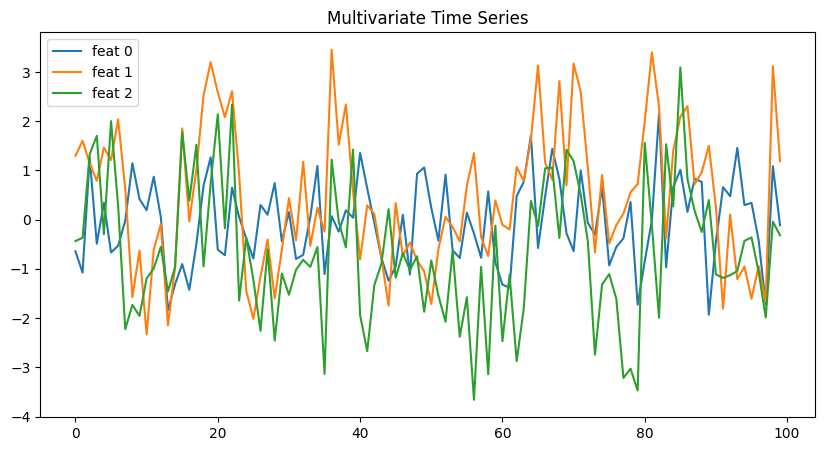

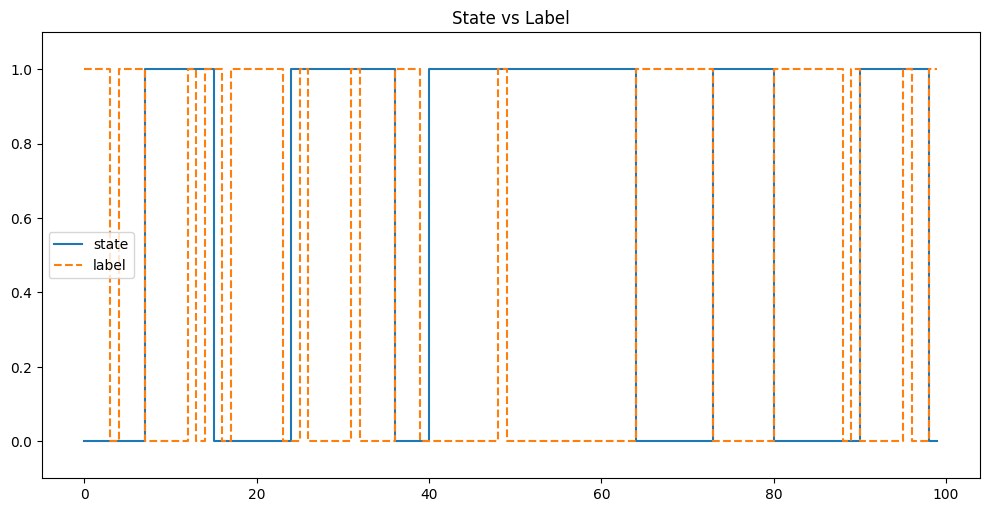

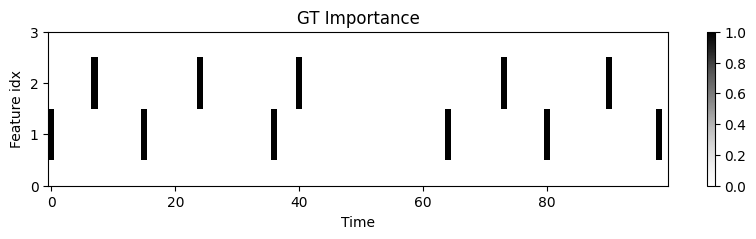

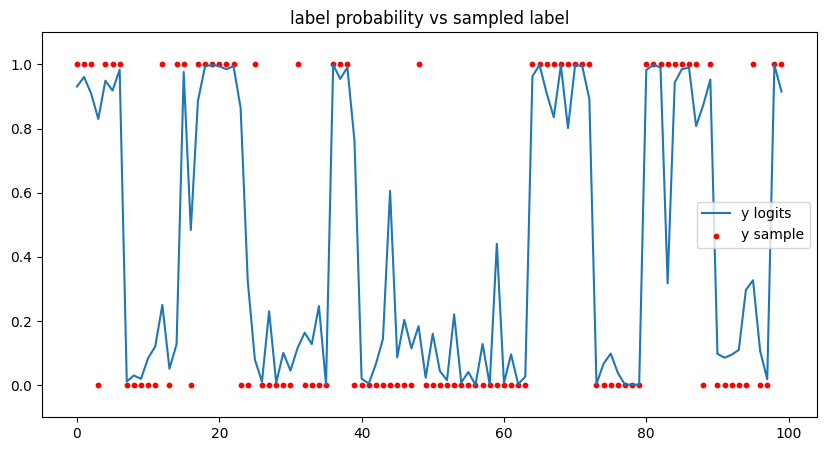

In [17]:
# Cell 4: Generate One Signal + Visualize
np.random.seed(234)
sig, y, states, masks, y_logits = create_signal(100, means, covs)

# 1) Feature time-series
plt.figure(figsize=(10,5))
for i in range(SIG_NUM):
    plt.plot(sig[i], label=f"feat {i}")
plt.legend(); plt.title("Multivariate Time Series"); plt.show()

# 2) Hidden State vs Label
plt.figure(figsize=(10,5))
plt.step(range(len(states)), states, where='post', label='state')
plt.step(range(len(y)),      y,      where='post', linestyle='--', label='label')
plt.ylim(-0.1,1.1); plt.legend();
plt.tight_layout()
plt.title("State vs Label"); plt.show()

# 3) Importance mask heatmap
plt.figure(figsize=(10,2))
plt.imshow(masks.T, aspect='auto', cmap='Greys', interpolation='nearest')
plt.xlabel("Time"); plt.ylabel("Feature idx"); plt.ylim(0,3); plt.title("GT Importance"); plt.colorbar(); plt.show()

# 4) Label probability vs sampled label
plt.figure(figsize=(10,5))
plt.plot(y_logits, label='y logits')
plt.scatter(range(len(y)), y, color='red', s=10, label='y sample')
plt.ylim(-0.1,1.1); plt.legend(); plt.title("label probability vs sampled label"); plt.show()


In [6]:
# Cell 5: Batch‐Generate & Save Dataset
def create_dataset(count, signal_len):
    Xs, Ys, Ss = [], [], []
    means, covs = init_distribution_params()
    for i in range(count):
        s, y, st, _, _ = create_signal(signal_len, means, covs)
        Xs.append(s)
        Ys.append(y)
        Ss.append(st)
    Xs = np.array(Xs)  # shape (N, SIG_NUM, T)
    Ys = np.array(Ys)  # shape (N, T)

    # 80/20 split
    split = int(0.8 * count)
    os.makedirs('./data/simulated_data', exist_ok=True)
    pickle.dump(Xs[:split], open('./data/simulated_data/x_train.pkl','wb'))
    pickle.dump(Xs[split:], open('./data/simulated_data/x_test.pkl','wb'))
    pickle.dump(Ys[:split], open('./data/simulated_data/y_train.pkl','wb'))
    pickle.dump(Ys[split:], open('./data/simulated_data/y_test.pkl','wb'))

    return Xs, Ys, Ss

# (Nothing to run here until you call create_dataset)


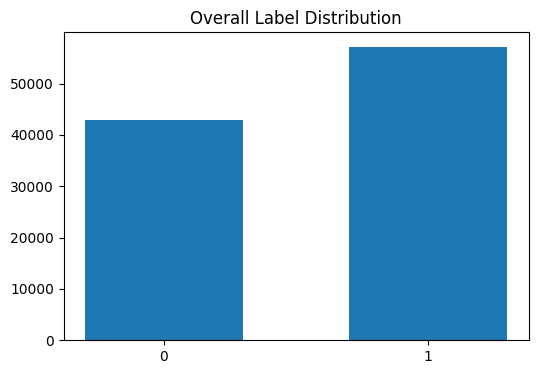

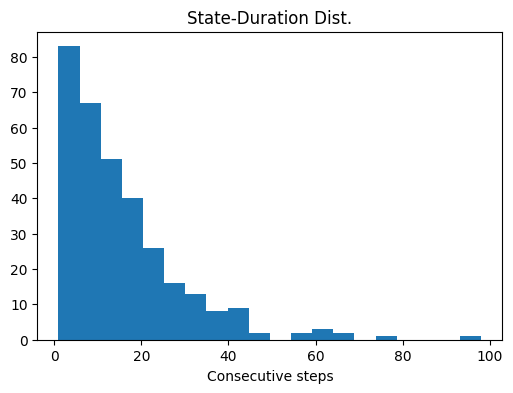

In [ ]:
# Cell 6: Quick Global Stats (after you’ve run create_dataset)
# For example:
dataset, labels, states = create_dataset(1000, 100)

# Histogram of overall label balance
plt.figure(figsize=(6,4))
plt.hist(labels.flatten(), bins=[-0.5,0.5,1.5], rwidth=0.6)
plt.xticks([0,1]); plt.title("Overall Label Distribution"); plt.show()

# Histogram of state-run lengths (first 50 series)
durations = []
for st_series in states[:50]:
    prev = st_series[0]; cnt = 1
    for s in st_series[1:]:
        if s == prev: cnt += 1
        else:
            durations.append(cnt)
            prev, cnt = s, 1
    durations.append(cnt)
plt.figure(figsize=(6,4))
plt.hist(durations, bins=20)
plt.xlabel("Consecutive steps"); plt.title("State-Duration Dist."); plt.show()


# Random debug score deeplift

In [ ]:
import numpy as np
score = np.load('/home/WinIT/score_deeplift.npy')
score
